In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, QuantumCircuit, Aer, execute
from qiskit.extensions import UnitaryGate

In [2]:
n = 6 # Length of |l> register
wt = np.pi/12 # Angle of rotation (Custom time step, e.g. π/12 for week or π/90 for day)
H = np.array([[1, wt], [wt, -1]]) # Hermitian matrix (Not used below)
v = np.sqrt(1+wt**2) # Absolute eigenvalue of hermitian matrix
T = [np.pi*2**i for i in range(n)] # List of evolution times

# Lists of unitary matrices (original, inverse and/or controlled ones)
U = [np.array([[np.cos(v*T[i])+1j*np.sin(v*T[i])/v, 1j*wt*np.sin(v*T[i])/v], [1j*wt*np.sin(v*T[i])/v, np.cos(v*T[i])-1j*np.sin(v*T[i])/v]]) for i in range(n)]
Udg = [np.array([[np.cos(v*T[i])-1j*np.sin(v*T[i])/v, -1j*wt*np.sin(v*T[i])/v], [-1j*wt*np.sin(v*T[i])/v, np.cos(v*T[i])+1j*np.sin(v*T[i])/v]]) for i in range(n)]
CU = [UnitaryGate(U[i], label='CU**'+str(i+1)).control() for i in range(n)]
CUdg = [UnitaryGate(Udg[i], label='CU†**'+str(i+1)).control() for i in range(n)]

simulator = Aer.get_backend('statevector_simulator')

position = [[1, 0]] # List of positions starting from initial one

for step in range(round(2*np.pi/wt)):
    l = QuantumRegister(n, 'l') # Binary representation of ϑ in reverse order
    b = QuantumRegister(1, 'b') # James Webb position
    a = QuantumRegister(1, 'a') # Ancillary qubit
    qc = QuantumCircuit(l, b, a)

    qc.initialize(position[step], b)
    qc.z(b) # Applying Z-gate allows to use hermitian matrix

    # Quantum Phase Estimation
    qc.h(l)
    qc.barrier()

    for i in range(len(l)):
        qc.append(CU[i], [l[i], b])
    qc.barrier()

    # Inverse Quantum Fourier Transform
    for i in range(len(l)):
        for k in range(i):
            qc.cp(-np.pi/2**(k+1), len(l)-1-i, len(l)-i+k)
        qc.h(len(l)-1-i)
    qc.barrier()

    # Inverse positive eigenvalue
    qc.cry(2*np.arcsin(1/(2*2**(len(l)-1))), 0, a)
    for i in range(1, len(l)):
        theta = np.arcsin(1/(2*2**(len(l)-i-1)))
        qc.mcry(2*theta, [0, i], a)
    qc.barrier()

    # Inverse negative eigenvalue
    qc.x(range(len(l)-1))
    qc.barrier()

    qc.cry(2*np.arcsin(-1/(2*2**(len(l)-1))), 0, a)
    for i in range(1, len(l)):
        theta = np.arcsin(-1/(2*2**(len(l)-i-1)))
        qc.mcry(2*theta, [0, i], a)
    qc.barrier()

    qc.x(range(len(l)-1))
    qc.barrier()

    # Quantum Fourier Transform
    for i in range(len(l)):
        qc.h(i)
        for k in range(len(l)-2, i-1, -1):
            qc.cp(np.pi/2**(k+1-i), i, k+1)
    qc.barrier()

    # Uncomputing Quantum Phase Estimtion
    for i in range(len(l), 0, -1):
        qc.append(CUdg[i-1], [l[i-1], b])
    qc.barrier()

    qc.h(l)

    job = execute(qc, simulator)
    result = job.result()
    statevector = result.get_statevector()
    x = np.real(statevector[2*2**len(l)]) # |10000000> state
    y = np.real(statevector[3*2**len(l)]) # |11000000> state
    solution = [x, y]/np.linalg.norm(np.array([x, y]))
    position.append(solution.tolist())

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


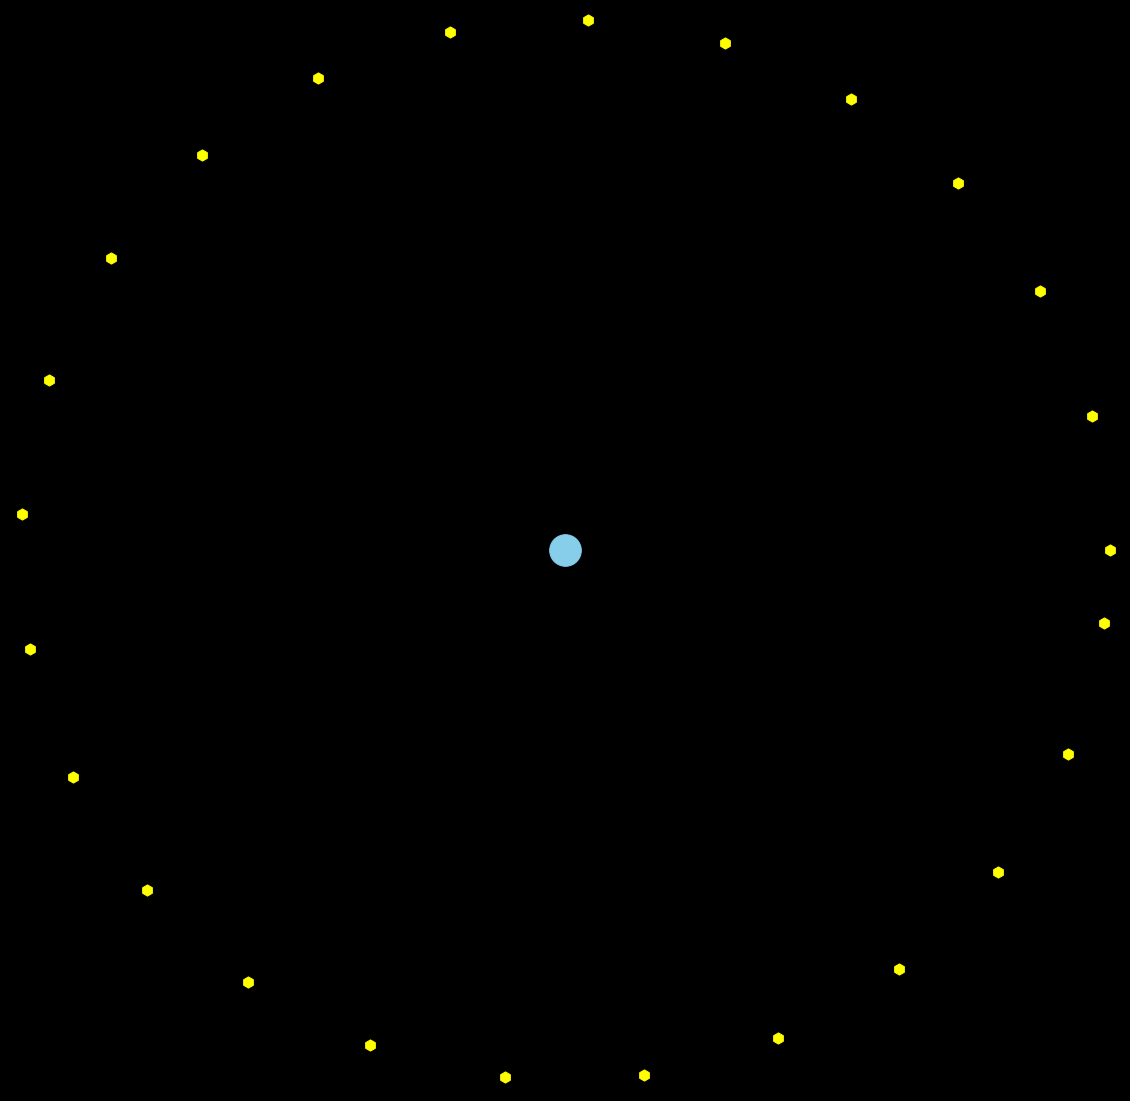

In [3]:
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams['figure.facecolor'] = 'black'
plt.axis('off')
plt.xlim([-1.025, 1.025])
plt.ylim([-1.025, 1.025])
plt.scatter(0, 0, s=1000, c='skyblue', marker='o')
for step in range(round(2*np.pi/wt)+1):
    plt.scatter(position[step][0], position[step][1], s=125, c='yellow', marker='h')
plt.show()